# Lab 3 Test-Time Scaling with transformers

# Part 1. Text-to-image test time scaling

In this part, we study test-time scaling for autoregressive (AR) text-to-image (T2I) models.
The model parameters are frozen. All improvements must come only from inference-time computation.

We will use an AR image-token generator to explore test-time scaling and evaluate the results based on:

-	image quality
-	prompt alignment
-   diversity

<!-- In this part, we will focus on test time scaling with AR t2i model -->

**Learning Objectives**

By the end of this lab, students should be able to:

	1.	Implement autoregressive image generation correctly
	2.	Understand and evaluate Best-of-N (BoN) as a test-time scaling method
	3.	Reason about how hyperparameters such as sampling temperature and CFG affect distributions
	4.	Compare multiple reward functions and analyze their correlation
	5.	Understand limitations of BoN and motivate more advanced test-time algorithms

### **Question 1.1** (Warm-up)

Complete the inference loop for an autoregressive T2I model.

At each inference step:

	1.	Compute next-token logits conditioned on previous tokens
	2.	Sample the next token
	3.	Append it to the sequence
	4.	Repeat until the full image token sequence is generated


Hints

-   Familiar with the model input and output
-	Pay attention to tensor shapes and caching
-	Sampling should be stochastic (not argmax)


In [2]:
# %% load janus-pro

# !git clone https://huggingface.co/deepseek-ai/Janus-Pro-7B
#git clone https://github.com/deepseek-ai/Janus.git
# !pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1#pip install torch==2.9.1 torchvision==0.24.1 torchaudio==2.9.1
# !pip install transformers==4.38.2
!pip install transformers==4.52.4
!pip install timm>=0.9.16
!pip install accelerate
!pip install sentencepiece
!pip install attrdict
!pip install einops
!pip install timm
# !pip install bitsandbytes==0.49.1

# !cd Janus

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.5 MB 7.7 MB/s            
     |████████████████████████████████| 3.1 MB 143.2 MB/s            
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
cd Janus/

/users/eleves-b/2023/arthur.buis/Documents/CSC_52002_Multimodal_Generative_AI/Janus


/users/eleves-b/2023/arthur.buis/.local/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
ls

demo/                    interactivechat.py         Makefile
generated_samples_test/  janus/                     pyproject.toml
generation_inference.py  janus_pro_tech_report.pdf  README.md*
images/                  LICENSE-CODE               requirements.txt
inference.py             LICENSE-MODEL


In [8]:
%pip install transformers==4.52.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 52.1 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 20.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.7 MB/s  0:00:00
  Attempting uninstall: huggingface-hub━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/6 [charset_normalizer]
    Found existing installation: huggingface_hub 1.3.4━━━━━━━━ 1/6 [charset_normalizer]
    Uninstalling huggingface_hub-1.3.4:━━━━━━━━━━━━━━━━━━━ 3/6 [huggingface-hub]
      Successfully uninstalled huggingface_hub-1.3.4━━━━━━━━━━ 3/6 [huggingface-hub]
  Attempting uninstall: tokenizers90m╺━━━━━━━━━━━━━━━━━━━ 3/6 [huggingface-hub]
    Found existing installation: tokenizers 0.22.2━━━━━━━━━━━━ 3/6 [huggingface-hub]
    Uninstalling tokenizers-0.22.2:╸━━━━━━━━━━━━━ 4/6 [tokenizers]]
      Successfully uninstalled tokenizers-0.22.2m━━━━━━━━━━━━━ 4/6 [tokenizers]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 4/6 [tokenizers]  WARNING: Failed to remove contents in a te

In [5]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
import tqdm
import matplotlib.pyplot as plt

### load Janus-Pro 1B
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

torch.cuda.empty_cache()

/users/eleves-b/2023/arthur.buis/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/eleves-b/2023/arthur.buis/.local/lib/python3.9/site-packages/transformers/models/auto/image_processing_auto.py:609: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.toke

In [13]:
@torch.inference_mode()
def generate_image(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    user_prompt: str,
    temperature: float = 1,
    num_images_per_prompt: int = 4,
    cfg_weight: float = 5,
    # fixed
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    # apply SFT format and system prompt
    conversation = [
        {
            "role": "<|User|>",
            "content": user_prompt,
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
        conversations=conversation,
        sft_format=vl_chat_processor.sft_format,
        system_prompt="",
    )
    prompt = sft_format + vl_chat_processor.image_start_tag

    # preprocess the prompts
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    ### here we assume CFG is used, so we need to duplicate the input_ids for cond and uncond
    tokens = torch.zeros((num_images_per_prompt*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(num_images_per_prompt*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((num_images_per_prompt, image_token_num_per_image), dtype=torch.int).cuda()

    # inference loop
    ######## STUDENT_ANSWER_START ########

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state
        
        # get the logits for next token
        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]
        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        # sample the token
        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)
        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)

        # prepare for netx step

        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)

    ######## STUDENT_ANSWER_END ########

    assert generated_tokens.shape == (num_images_per_prompt, image_token_num_per_image)

    # decode image tokens
    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[num_images_per_prompt, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu()   # [B, C, H, W] [-1,1]

    # convert to pil images
    dec = dec.numpy().transpose(0, 2, 3, 1)
    dec = np.clip((dec + 1) / 2 * 255, 0, 255)
    visual_img = np.zeros((num_images_per_prompt, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    # store images in a list
    image_list = []
    for i in range(num_images_per_prompt):
        image_list.append(PIL.Image.fromarray(visual_img[i]))

    return image_list

In [ ]:
### test the image generation function, choose freely your favorite prompt
#user_prompt = "A photo of a realistic but impossible object."
user_prompt = "A photo of a croissant." # my favorite one
#user_prompt = "A cat holding a plate with the word 'CAT' written in large letters."
#user_prompt = "A green apple on the left of two red apple, both on a white plate, studio lighting."

num_images_per_prompt = 4
save_dir = "generated_samples_test"
os.makedirs(save_dir, exist_ok=True)

image_list = generate_image(
    vl_gpt,
    vl_chat_processor,
    user_prompt,
    num_images_per_prompt=num_images_per_prompt,
)

for i in range(num_images_per_prompt):
    save_path = os.path.join(save_dir, "img_{}.jpg".format(i))
    image_list[i].save(save_path)


### **Question 1.2**

Explore Best-of-N (BoN) Scaling

Task

For each of 2-3 prompts:

	1.	Generate N independent samples using the same prompt
	2.	Compute the reward for each sample
	3.	Select the sample with the highest reward (Best-of-N)

Run this experiment for increasing values of N.

Plot one curve per prompt (Best reward vs. number of N), and the average.

Analysis questions

	1.	Does the improvement saturate? Why?
	2.	Is the improvement logarithmic, linear, or diminishing?

In [16]:
from transformers import CLIPProcessor, CLIPModel
from typing import List, Optional, Dict, Any, Tuple

# -----------------------------
# CLIP reranker (best-of-N)
# -----------------------------
class ClipReranker:
    def __init__(self, model_name: str = "openai/clip-vit-base-patch32"):
        self.clip_model = CLIPModel.from_pretrained(model_name).cuda().eval()
        self.clip_proc = CLIPProcessor.from_pretrained(model_name)

    @torch.inference_mode()
    def score(self, prompt_text: str, images: List[PIL.Image.Image]) -> torch.Tensor:
        inputs = self.clip_proc(
            text=[prompt_text] * len(images),
            images=images,
            return_tensors="pt",
            padding=True,
        )
        inputs = inputs.to(self.clip_model.device)
        out = self.clip_model(**inputs)
        # calculate cosine similarity
        img = out.image_embeds / out.image_embeds.norm(dim=-1, keepdim=True)
        txt = out.text_embeds / out.text_embeds.norm(dim=-1, keepdim=True)
        sim = (img * txt).sum(dim=-1)
        return sim.detach().cpu()

    def select_best(self, prompt_text: str, images: List[PIL.Image.Image]) -> Tuple[int, float, torch.Tensor]:
        scores = self.score(prompt_text, images)
        best_i = int(scores.argmax().item())
        best_s = float(scores[best_i].item())
        return best_i, best_s, scores

# initialize the CLIP reranker
clip_reranker = ClipReranker()

You need to generate multiple images per prompt.
For each prompt, generate N = num_images_per_prompt * num_batches images, and compute the reward for each image.
Then, for each prompt, group the images into num_batches groups of size num_images_per_prompt, and select the best image from each group.
Compute the average reward of the selected images for each prompt.
Then compute the average reward across all prompts for the current N.

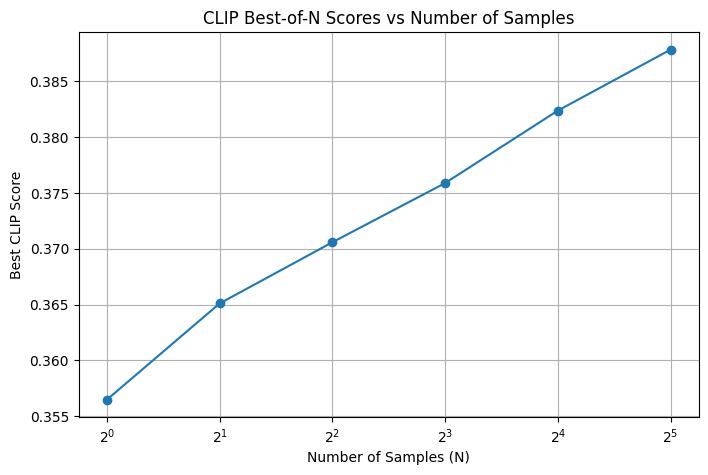

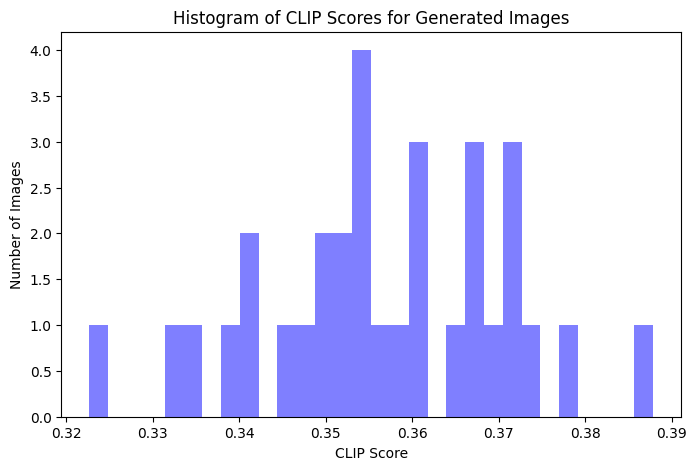

In [21]:
import random

prompt_list = [
    "A photo of a realistic but impossible object.",
    "A photo of a croissant.",
    "A cat holding a plate with the word 'CAT' written in large letters.",
    "A green apple on the left of two red apple, both on a white plate, studio lighting.",
]

save_dir = "generated_samples_BoN_CLIP"
os.makedirs(save_dir, exist_ok=True)

# total 64 images per prompt
# here you do not need to generate 64 images, it can be 32 or even 16, the point is to get a feeling of how BoN work and plot the cerve
# then investigate how the inference parameters will influence the BoN performance (or not).
num_batches = 8
num_images_per_prompt = 4


######## STUDENT_ANSWER_START ########

user_prompt = prompt_list[2] # try another one
images_list = generate_image(
    vl_gpt,
    vl_chat_processor,
    user_prompt,
    num_images_per_prompt=num_images_per_prompt*num_batches,
)
clip_scores_list = clip_reranker.score(user_prompt, images_list)
M= 100

for i in range(num_images_per_prompt*num_batches):
    save_path = os.path.join(save_dir, "img_{}.jpg".format(i))
    images_list[i].save(save_path)

N_list = [1, 2, 4, 8, 16, 32]
clip_BoN_list = [torch.mean(clip_scores_list)]
for i in N_list[1:]:
    max_list = []
    for j in range(M):
        sublist = random.sample(clip_scores_list.tolist(), i)
        max_list.append(max(sublist))
    clip_BoN_list.append(sum(max_list)/M)


######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list, bins=30, alpha=0.5, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

### **Question 1.3** Sampling Hyperparameters


**Repeat** Question 1.2 while varying the sampling temperature T:
T \in \{0.7, 1.0, 1.3\}

Visualizations

-	Image grids for each temperature
-	Best-of-N reward curves at different temperatures

Analysis questions

	1.	How does temperature affect diversity?
	2.	For which temperatures does BoN help the most?


#### Bonus: classifier free guidance (CFG)

What is CFG in AR models, how does it change the sampling behavior of the models.

##### Introduction to CFG
Classifier-Free Guidance (CFG) is a conditional sampling method that combines a model’s conditional and unconditional predictions to amplify the influence of the condition at decoding time, without training a separate classifier. For an autoregressive model, we compute conditional logits $\ell_{\text{cond}}$ (given condition c) and unconditional logits $\ell_{\text{uncond}}$ (with the condition removed). We then form guided logits $\ell_{\text{cfg}} = \ell_{\text{uncond}} + s(\ell_{\text{cond}}-\ell_{\text{uncond}})$, where $s$ is the guidance scale. Sampling from $\text{softmax}(\ell_{\text{cfg}}/T)$ increases the probability of tokens that are more consistent with the condition. Increasing $s$ typically improves condition adherence and can increase reward when the reward aligns with the condition, but it often reduces diversity and can cause overconfident or repetitive outputs if set too high.

CFG was originally invented for diffusion models, but is widely used for AR visual generation, see https://sander.ai/2022/05/26/guidance.html


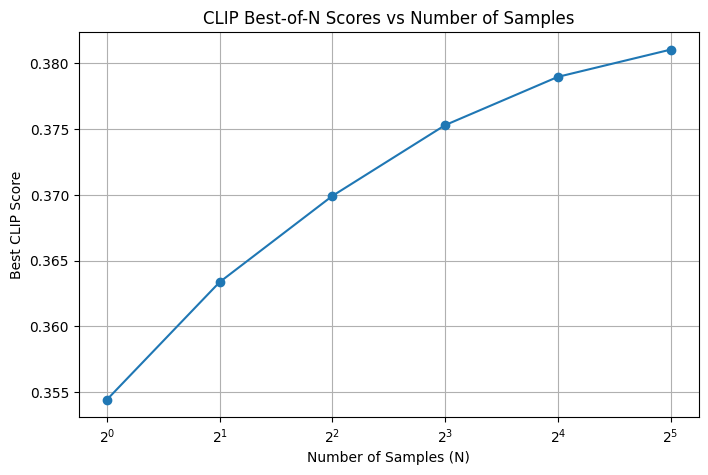

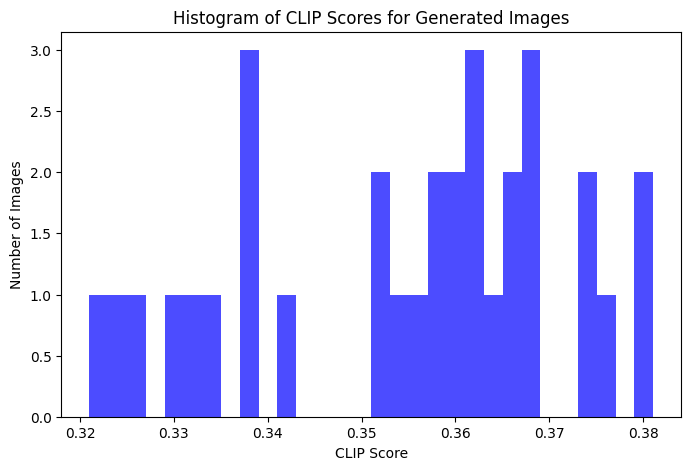

In [23]:
### try temperature 0.7

save_dir = "generated_samples_BoN_CLIP_temp07"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########

temperature = 0.7
images_list = generate_image(
    vl_gpt,
    vl_chat_processor,
    user_prompt,
    temperature=temperature,
    num_images_per_prompt=num_images_per_prompt*num_batches,
)

clip_scores_list_temp07 = clip_reranker.score(user_prompt, images_list)
M= 100

for i in range(num_images_per_prompt*num_batches):
    save_path = os.path.join(save_dir, "img_{}.jpg".format(i))
    images_list[i].save(save_path)

N_list = [1, 2, 4, 8, 16, 32]
clip_BoN_list_temp07 = [torch.mean(clip_scores_list_temp07)]
for i in N_list[1:]:
    max_list = []
    for j in range(M):
        sublist = random.sample(clip_scores_list_temp07.tolist(), i)
        max_list.append(max(sublist))
    clip_BoN_list_temp07.append(sum(max_list)/M)
    
######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_temp07, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_temp07, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

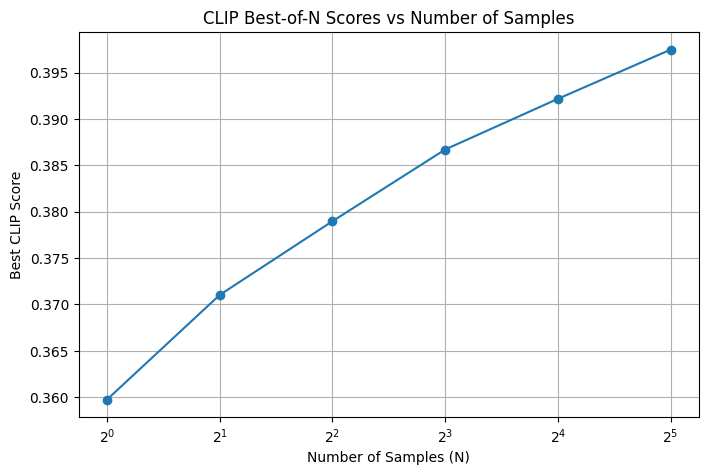

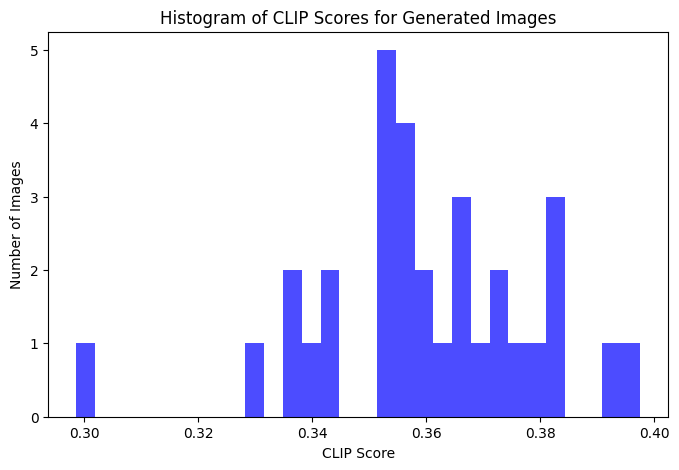

In [24]:
# ### try temperature 1.5 (optional)
save_dir = "generated_samples_BoN_CLIP_temp15"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########

temperature = 1.5
images_list = generate_image(
    vl_gpt,
    vl_chat_processor,
    user_prompt,
    temperature=temperature,
    num_images_per_prompt=num_images_per_prompt*num_batches,
)
clip_scores_list_temp15 = clip_reranker.score(user_prompt, images_list)
M= 100

for i in range(num_images_per_prompt*num_batches):
    save_path = os.path.join(save_dir, "img_{}.jpg".format(i))
    images_list[i].save(save_path)

N_list = [1, 2, 4, 8, 16, 32]
clip_BoN_list_temp15 = [torch.mean(clip_scores_list_temp15)]
for i in N_list[1:]:
    max_list = []
    for j in range(M):
        sublist = random.sample(clip_scores_list_temp15.tolist(), i)
        max_list.append(max(sublist))
    clip_BoN_list_temp15.append(sum(max_list)/M)
    



######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_temp15, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_temp15, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

What if the temperature is very small?

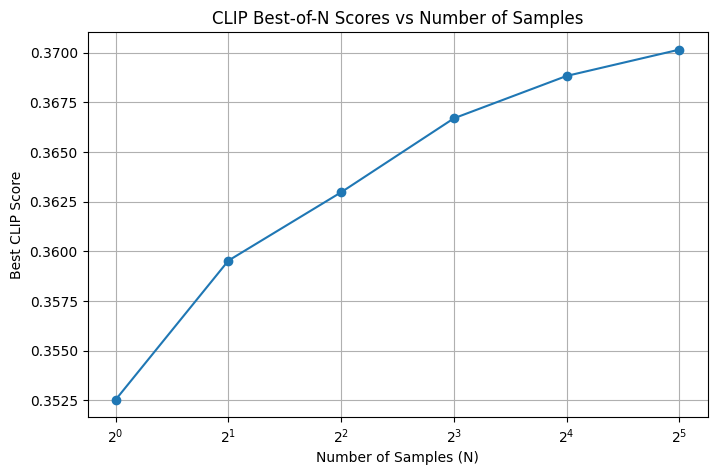

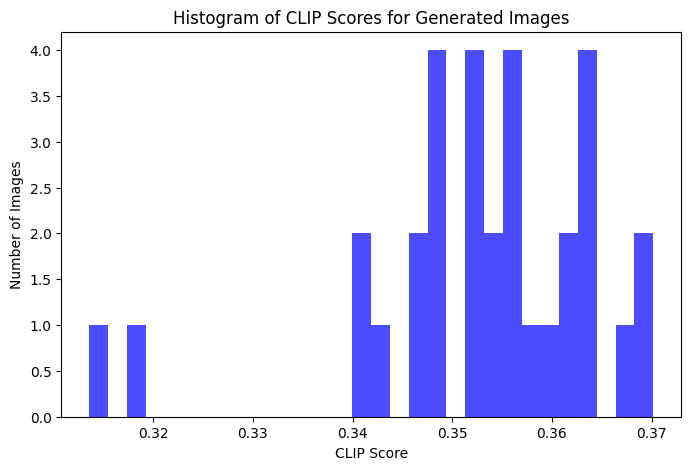

In [25]:
# ### try extreme temperature 0.0001, remembner that very low temperature to approach greedy decoding, can confirm that via generated images (optional)
save_dir = "generated_samples_BoN_CLIP_temp0001"
os.makedirs(save_dir, exist_ok=True)


######## STUDENT_ANSWER_START ########

temperature = 1e-4
images_list = generate_image(
    vl_gpt,
    vl_chat_processor,
    user_prompt,
    temperature=temperature,
    num_images_per_prompt=num_images_per_prompt*num_batches,
)
clip_scores_list_temp01 = clip_reranker.score(user_prompt, images_list)
M= 100

for i in range(num_images_per_prompt*num_batches):
    save_path = os.path.join(save_dir, "img_{}.jpg".format(i))
    images_list[i].save(save_path)

N_list = [1, 2, 4, 8, 16, 32]
clip_BoN_list_temp01 = [torch.mean(clip_scores_list_temp01)]
for i in N_list[1:]:
    max_list = []
    for j in range(M):
        sublist = random.sample(clip_scores_list_temp01.tolist(), i)
        max_list.append(max(sublist))
    clip_BoN_list_temp01.append(sum(max_list)/M)


######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_temp01, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_temp01, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

With such a small temperature, we observe only a limited diversity in the output images: the cat is always the same color, with the same color and position of the plate.

In comparison, the temperature 0.7 allows diversity; and the temperature 1.5 is so high that it even cause some cats to have annormal shape and look unrealistic, which shows that the optimal temperature is somewhere around 0.5 to 1.0

In [26]:
## different CFG scale, explore how cfg scale will affect the results (optional)

save_dir = "generated_samples_BoN_CLIP_cfg1"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########

#didn't get enought time for this one question :(

######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_cfg1, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_cfg1, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

NameError: name 'clip_BoN_list_cfg1' is not defined

<Figure size 800x500 with 0 Axes>

In [27]:
## different CFG scale, what happens if we use a very large CFG scale like 10 or 100 (optional)

save_dir = "generated_samples_BoN_CLIP_cfg10"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########

#no time for this one neither

######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_cfg10, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_cfg10, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

NameError: name 'clip_BoN_list_cfg10' is not defined

<Figure size 800x500 with 0 Axes>

### **Question 1.4** Alternative Rewards

Repeat Question 1.2 using a second reward function, for example:

-	aesthetic score
-	image reward
-	counting (part of GenEval)

Required analysis

	1.	Plot reward₁ vs. reward₂ for all samples
	2.	Show correlation

Discussion questions

	1.	Are the rewards correlated or conflicting?
	2.	Can BoN over-optimize one reward at the expense of another?
	3.	Which reward better matches human judgment?

#### Bonus
Look into the generated data, is your favorate image the same as the one with highest score?

In [28]:
!wget https://github.com/christophschuhmann/improved-aesthetic-predictor/raw/refs/heads/main/sac+logos+ava1-l14-linearMSE.pth

--2026-01-28 22:47:54--  https://github.com/christophschuhmann/improved-aesthetic-predictor/raw/refs/heads/main/sac+logos+ava1-l14-linearMSE.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/christophschuhmann/improved-aesthetic-predictor/refs/heads/main/sac%2Blogos%2Bava1-l14-linearMSE.pth [following]
--2026-01-28 22:47:55--  https://raw.githubusercontent.com/christophschuhmann/improved-aesthetic-predictor/refs/heads/main/sac%2Blogos%2Bava1-l14-linearMSE.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3714759 (3.5M) [application/octet-stream]
Saving to: ‘sac+logos+ava1-l14-linearMSE.pth’

sac+logos+ava1-l14- 100%[===================>]   3.54M  --.-KB/s    in 0.07s   

2026-01-28 22:47:55 (50.7 MB/s) - ‘sac+logos+ava1-l14-linearMSE.pth’ saved [3714759/3714759]



In [29]:
# -----------------------------
# aesthetic score model
# -----------------------------

from transformers import AutoProcessor, AutoModelForImageClassification
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )
    @torch.no_grad()
    def forward(self, embed):
        return self.layers(embed)


class AestheticScorer(torch.nn.Module):
    def __init__(self, dtype, device):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
        self.mlp = MLP().to(device)
        state_dict = torch.load("sac+logos+ava1-l14-linearMSE.pth", map_location="cpu")
        self.mlp.load_state_dict(state_dict)
        self.dtype = dtype
        self.device = device
        self.eval()

    @torch.no_grad()
    def __call__(self, images):
        inputs = self.processor(images=images, return_tensors="pt")
        inputs = {k: v.to(self.dtype).to(self.device) for k, v in inputs.items()}
        embed = self.clip.get_image_features(**inputs)
        # normalize embedding
        embed = embed / torch.linalg.vector_norm(embed, dim=-1, keepdim=True)
        return self.mlp(embed).squeeze(1)

aesthetic_scorer = AestheticScorer(dtype=torch.float16, device="cuda")

found 32 images
found 32 images
found 32 images
found 32 images
found 4 images


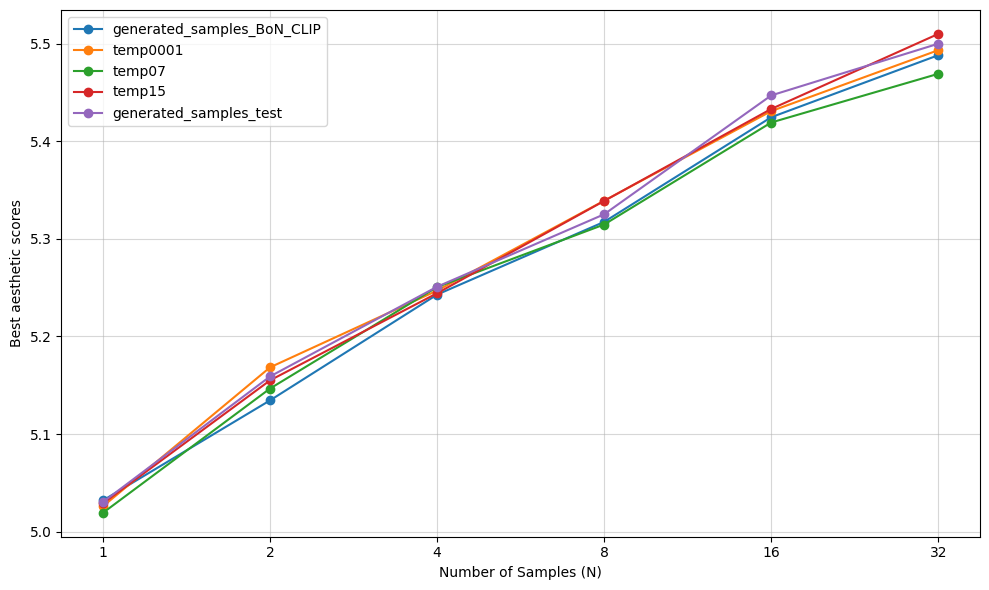

In [31]:
from PIL import Image
import re
pattern = re.compile(r'^img_(\d+)\.jpg$')
## calculate aesthetic scores for all images generated and stored before

save_dir = "generated_samples_BoN_aesthetic"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########

save_dirs = [
    "generated_samples_BoN_CLIP", 
    "generated_samples_BoN_CLIP_temp0001",
    "generated_samples_BoN_CLIP_temp07",
    "generated_samples_BoN_CLIP_temp15",
    "generated_samples_test"]
aesthetic_bon_results = {}
M= 100

for save_dir in save_dirs:
    filenames = [f for f in os.listdir(save_dir) if pattern.match(f)]
    filenames.sort(key=lambda x: int(pattern.match(x).group(1)))
    #load all images
    for filename in filenames:
        if filename.endswith(".jpg"):
            img_path = os.path.join(save_dir, filename)
            img = Image.open(img_path).convert("RGB") 
            images_list.append(img)

    if not images_list:
        continue
    print(f"found {len(filenames)} images")
    scores = aesthetic_scorer(images_list).detach().cpu().tolist()

    folder_bon_curve = [np.mean(scores)]
    for n in N_list[1:]:
        max_samples = []
        for _ in range(M):
            sample = random.sample(scores, min(n, len(scores)))
            max_samples.append(max(sample))
        folder_bon_curve.append(np.mean(max_samples))
    
    aesthetic_bon_results[save_dir] = folder_bon_curve

plt.figure(figsize=(10, 6))

for folder, bon_curve in aesthetic_bon_results.items():
    plt.plot(N_list, bon_curve, marker='o', label=folder.replace("generated_samples_BoN_CLIP_", ""))

plt.xscale('log', base=2)
plt.xticks(N_list, N_list)
plt.xlabel('Number of samples')
plt.ylabel('Best aesthetic scores')
plt.grid(True, which="both", ls="-", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

######## STUDENT_ANSWER_END ########


Even though a high temperature gives overal results that seem worst (at least formy personal appreciation) this becomes the best curves when increasing N: indeed, more diversity includes higher chances of getting something good

In [32]:
## plot both rewards against each other, using two y-axis (optional)

######## STUDENT_ANSWER_START ########
#no time neither
######## STUDENT_ANSWER_END ########


### **Question 1.5** Beyond BoN (Open-Ended)

Propose or learn one alternative tts algorithm for AR model that is not Best-of-N.

Describe:

	1.	How it works
	2.	Why it may outperform BoN
	3.	What additional cost it introduces (if any)


Here are some literatures you can chose from:

- https://arxiv.org/abs/2511.21185
- https://arxiv.org/abs/2501.13926
- https://openreview.net/forum?id=EjyCJySMrD

####### STUDENT_ANSWER_START ########

The third paper proposes a beam search approach that looks promising. Indeed, it guides the token generation by using an RL method, and by exploring further tokens generated and "branching", so cutting the less promising paths explored. It got results way higher than what appears reachable with BoN

####### STUDENT_ANSWER_END ########

### Algorithm description:

### **Question 1.6** TTS vs. RL (Optional)

Read the following paper, try to answer the relationship between TTS and RL

https://arxiv.org/abs/2504.13837

<!-- Explore different prompt engineering techniques. How does varying the prompt structure (e.g., adding descriptive adjectives, specifying styles, using negative prompts) affect the diversity and adherence of the generated images to the user's intent? Provide examples of prompts and the corresponding generated images to illustrate your findings. -->

####### STUDENT_ANSWER_START ########

no time still...

####### STUDENT_ANSWER_END ########

# Part 2: Test-Time Scaling and Inference Compute for VLMs

In this part, we explore the concept of **Inference-Time Scaling (Test-Time Compute)**. We will investigate whether a Vision-Language Model (VLM) can "think harder" by generating multiple diverse candidates and then selecting the best one through self-verification.

We will use the **InfoVQA** dataset, which consists of complex documents, infographics, and charts that require detailed visual reasoning.

### Core Concepts:
1. **Oracle Best-of-N**: The upper-bound performance if we could perfectly pick the correct answer from N samples.
2. **VLM-as-Verifier**: Using the model itself to rank its own outputs based on the visual evidence.
3. **Scaling Laws**: Investigating how accuracy improves as we increase N (the number of samples/compute budget).

### Theoretical Questions (Part 1)

**Q1.1:** What is the fundamental difference between scaling *parameters* (training compute) and scaling *inference tokens* (test-time compute)?

Scaling parameters increases the model’s capacity by training a larger network, which permanently improves its representations but requires expensive retraining.
Scaling inference tokens keeps the model fixed and allocates more compute at test time (e.g., sampling multiple answers), trading latency and cost for potentially better results.

**Q1.2:** If a model has a $10\%$ chance of getting an answer right in a single try ($p=0.1$), what is the probability that it gets it right at least once in $N=8$ independent trials?

The probability of failing once is $1−0.1=0.9$
Failing all 8 times is $0.9^8≈0.43$
So the probability of being correct at least once is $1−0.9^8≈57%$

In [1]:
# 1. Install necessary libraries
#pip install -q git+https://github.com/huggingface/transformers accelerate bitsandbytes datasets Pillow matplotlib

import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import re
from datasets import load_dataset
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

# 2. Load the model (Qwen2-VL-2B)
model_id = "Qwen/Qwen2-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

/users/eleves-a/2023/sascha.rode/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


## Data Preparation: InfoVQA

We will load random samples from the InfoVQA dataset. To ensure stability on the GPU, we will resize images as needed.

Load as many samples as you can, but reduce the number according to your GPU access.

In [2]:
# Function to resize images
def resize_longest_side(img, max_side=768):
    w, h = img.size
    scale = max_side / max(w, h)
    if scale >= 1:
        return img
    new_size = (int(w * scale), int(h * scale))
    return img.resize(new_size, Image.BICUBIC)

In [3]:
print("Loading InfoVQA dataset...")
dataset = load_dataset("Ahren09/InfoVQA", split="train", streaming=True)

infovqa_tasks = []
# Shuffle and take samples
for i, item in enumerate(dataset.shuffle(seed=42).take(200)):
    img = item["image"].convert("RGB")
    img = resize_longest_side(img)

    infovqa_tasks.append({
        "id": i + 1,
        "image": img,
        "question": item["question"],
        "ground_truth": item["answer"][0]
    })

print(f"Loaded {len(infovqa_tasks)} tasks.")

Loading InfoVQA dataset...
Loaded 200 tasks.


## Exercise 1: Diverse Sample Generation

To make Best-of-N work, we need **diversity**. If the model always gives the same answer, scaling N provides no benefit.
Implement a function that generates N samples using temperature sampling with high diversity parameters.

In [ ]:
def generate_samples(image, question, n=1):
    """Generates N diverse independent answers."""

    ######## STUDENT_ANSWER_START ########

    messages = [{
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image
            },
            {"type": "text", "text": question},
        ],
    }]
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
    )

    inputs = processor(text=[text], images=[image], return_tensors="pt").to("cuda")
    answers = []

    for _ in range(n):
        with torch.no_grad():
            outputs_ids = model.generate(
                **inputs, 
                max_new_tokens=128,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                use_cache=True
            )

        prompt_length = inputs.input_ids.shape[1]
        gen_text = processor.batch_decode(outputs_ids[:, prompt_length:], skip_special_tokens=True)[0]
        answers.append(gen_text)
        del outputs_ids

    return answers

    ######## STUDENT_ANSWER_END ########

### Theoretical Questions (Part 2)

**Q2.1:** Explain the role of `top_p` (nucleus sampling) and `top_k`.

top_p means that the model selects the smallest token set whose cumulative probability overcomes the threshold $p$ (then p belongs to [0, 1], otherwise it makes no sense). 

top_k means that the model selects only the k most probable tokens. This is a much simpler metric, in which the set always have the same size

**Q2.2:** What happens to the probability distribution of the next token as `temperature` reaches infinity?

Temperature modifies the logits before applying the Softmax according to the formula $P_i = \frac{e^{l_i / T}}{\sum e^{l_j / T}}$.

when $T$ tend to infinity, the terme $l_i / T$ tends to 0 for all tokens. Thus the $e^{l_i / T}$ become equal to 1. The probability distribution then becomes uniform: each token in the vocabulary has exactly the same probability of being selected ($1 / \text{size\_vocab}$), making the model’s outputs completely random and incoherent.

## Exercise 2: The Self-Verifier

Now, implement the `verify_samples` function. The model should look at the image and the question, and then rate a candidate answer.

In [8]:
def verify_samples(image, question, samples):
    """Asks the VLM to score each candidate answer."""
    ######## STUDENT_ANSWER_START ########
    yes_token_id = processor.tokenizer.encode("Yes", add_special_tokens=False)[-1]
    no_token_id = processor.tokenizer.encode("No", add_special_tokens=False)[-1]
    confidences = []
    
    for sample in samples:
        v_prompt = f"Question: {question}\nProposed Answer: {sample}\nIs this answer correct? Answer Yes or No."
        msg = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": v_prompt}]}]
        text = processor.apply_chat_template(msg, tokenize=False, add_generation_prompt=True)
        
        inputs = processor(text=[text], images=[image], return_tensors="pt").to("cuda")
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[:, -1, :]
            relevant_logits = logits[:, [yes_token_id, no_token_id]]
            probs = torch.softmax(relevant_logits, dim=-1)
            confidences.append(probs[0, 0].item())
        
            del outputs, logits, relevant_logits, probs, inputs

    return np.array(confidences)

    ######## STUDENT_ANSWER_END ########

## Exercise 3: Plotting the Scaling Curve

Finally, run the experiment for $N = [1, 2, 4, 8, 16, 32]$. For each N, calculate both Oracle and Verifier accuracy.

If your GPU access is limited, reduce the maximum value of N.

In [33]:
from tqdm.auto import tqdm



######## STUDENT_ANSWER_START ########

In [35]:
def is_correct(predicted, target):
    if isinstance(target, list):
        return any(t.lower() in predicted.lower() for t in target)
    
    # Si c'est une string classique
    return target.lower() in predicted.lower()

for n in n_values:
    print(n)
    oracle_correct = 0
    verifier_correct = 0
    total = len(all_samples_data)
    
    for data in all_samples_data:
        # On ne prend que les n premiers échantillons
        current_samples = data["samples"][:n]
        current_confidences = data["confidences"][:n]
        target = data["target"]
        
        # Calcul Oracle : Est-ce qu'AU MOINS UNE des n réponses est correcte ?
        is_any_correct = any(is_correct(s, target) for s in current_samples)
        if is_any_correct:
            oracle_correct += 1
            
        # Calcul Verifier : Est-ce que la réponse avec le plus haut score est correcte ?
        best_idx = np.argmax(current_confidences)
        if is_correct(current_samples[best_idx], target):
            verifier_correct += 1
            
    oracle_results.append(oracle_correct / total * 100)
    verifier_results.append(verifier_correct / total * 100)



######## STUDENT_ANSWER_END ########


NameError: name 'n_values' is not defined

## Final Discussion

**Q3.1:** Looking at your graph, does the Verifier accuracy keep up with the Oracle potential? Why or why not?

No, the Verifier does not keep up with the Oracle’s potential. The Oracle reaches a plateau at 85% as early as \(N = 4\), while the Verifier drops back to 75%. This illustrates a *verifiability gap*: the QWen model often generates the correct answer (latent potential), but its self-verifier fails to reliably distinguish it from hallucinated answers when faced with a large number of candidates (high \(N\)).

**Q3.2:** What are the compute costs of this strategy? If you wanted to deploy this in a real app, how would you decide what \(N\) to use?

The cost scales linearly: \(O(N \times \text{Inference})\). Each additional sample consumes GPU resources proportional to its sequence length. For a real-world application, I would choose \(N = 4\). This is the optimal point on the graph where the Verifier reaches its maximum accuracy (80%) before selection noise causes performance to degrade.

**Q3.3:** Can you think of a way to improve the Verifier without making it look at the image \(N\) times? (Hint: Batching or different prompting).

- Feed the \(N\) candidate answers in a single forward pass to reduce latency, instead of reprocessing the image \(N\) times (batching).
- Instead of assigning independent Yes/No scores, ask the model to compare the \(N\) answers jointly within a single prompt and select the most coherent one (majority voting / comparative prompting).
- Use a reward model trained with reinforcement learning to better exploit the base model’s latent potential without degrading accuracy at higher \(N\).


<!-- ### **Question 1.7**

Perform a qualitative analysis of the generated images. Identify common failure modes or artifacts produced by the model. Are there certain types of concepts or attributes that the model consistently struggles to represent accurately? How do these qualitative observations correlate with the quantitative CLIP scores? -->